In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create output directory if it doesn't exist
os.makedirs('output/hmm', exist_ok=True)

# Load dataset
df = pd.read_csv(r"Indel\GUIDE-Seq.csv")

# Display dataset structure
print(df.head())

# Basic statistics
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Summary of numerical columns
print(df.describe())


                        DNA                     crRNA  label  read  \
0  GCTGCCAGTACAGGCTCCCCCTCG  GCAGCCAGTACA_GCTCACCATGG    0.0   0.0   
1  GCTGCCAGTACAGGCTCCCCCTCG  GCAGCCAGTACAG_CTCACCATGG    0.0   0.0   
2  TACTAGAGTGACAAGTCACACAAT  G_CTAGAGTCACAAGTCCCACAGG    0.0   0.0   
3  -C_TAGAGTGACAAGTCACACAAT  -GCTAGAGTCACAAGTCCCACAGG    0.0   0.0   
4  ACAGCGAGTACAAGCTCATCATGA  GCAGCCAGTAC_AGCTCACCATGG    0.0   0.0   

                                                pair  
0  GCAGCCAGTACA_GCTCACCATGG|GCTGCCAGTACAGGCTCCCCCTCG  
1  GCAGCCAGTACAG_CTCACCATGG|GCTGCCAGTACAGGCTCCCCCTCG  
2  G_CTAGAGTCACAAGTCCCACAGG|TACTAGAGTGACAAGTCACACAAT  
3  -GCTAGAGTCACAAGTCCCACAGG|-C_TAGAGTGACAAGTCACACAAT  
4  GCAGCCAGTAC_AGCTCACCATGG|ACAGCGAGTACAAGCTCATCATGA  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213933 entries, 0 to 213932
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DNA     213933 non-null  object 
 1   crRNA   213933 non-n

In [2]:
df = df.drop(columns=["pair"])


In [3]:
from sklearn.preprocessing import LabelEncoder

def encode_sequence(sequence, max_length=23):
    """Convert a DNA sequence into a numerical representation"""
    mapping = {'A': 0, 'T': 1, 'G': 2, 'C': 3, '-': 4, '_': 5}
    return [mapping[ch] if ch in mapping else 6 for ch in sequence] + [6] * (max_length - len(sequence))

# Apply encoding
df["DNA_encoded"] = df["DNA"].apply(lambda x: encode_sequence(str(x)))
df["crRNA_encoded"] = df["crRNA"].apply(lambda x: encode_sequence(str(x)))

# Convert list to numpy array for ML models
df["DNA_encoded"] = df["DNA_encoded"].apply(lambda x: np.array(x))
df["crRNA_encoded"] = df["crRNA_encoded"].apply(lambda x: np.array(x))


In [4]:
import numpy as np

def needleman_wunsch(seq1, seq2, match=1, mismatch=-1, gap=-2):
    """Computes alignment score using Needleman-Wunsch Algorithm."""
    n, m = len(seq1), len(seq2)
    dp = np.zeros((n + 1, m + 1))

    # Initialize DP matrix
    for i in range(n + 1):
        dp[i][0] = i * gap
    for j in range(m + 1):
        dp[0][j] = j * gap

    # Fill DP table
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            match_mismatch = dp[i - 1][j - 1] + (match if seq1[i - 1] == seq2[j - 1] else mismatch)
            delete = dp[i - 1][j] + gap
            insert = dp[i][j - 1] + gap
            dp[i][j] = max(match_mismatch, delete, insert)

    return dp[n][m]

# Compute alignment scores for all pairs
df["alignment_score"] = df.apply(lambda row: needleman_wunsch(row["DNA"], row["crRNA"]), axis=1)


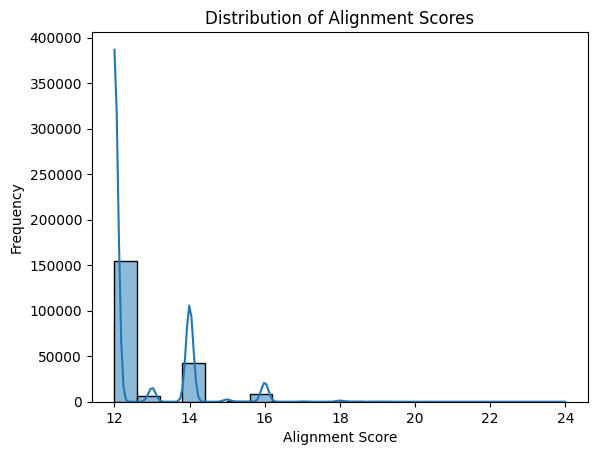

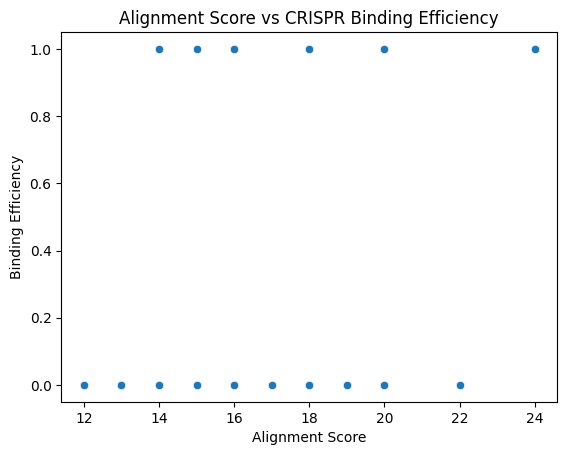

In [5]:
sns.histplot(df["alignment_score"], bins=20, kde=True)
plt.title("Distribution of Alignment Scores")
plt.xlabel("Alignment Score")
plt.ylabel("Frequency")
plt.show()

sns.scatterplot(x=df["alignment_score"], y=df["label"])
plt.title("Alignment Score vs CRISPR Binding Efficiency")
plt.xlabel("Alignment Score")
plt.ylabel("Binding Efficiency")
plt.show()


In [6]:
# Step 1: Compute mismatch count
df["mismatch_count"] = df.apply(lambda row: sum(a != b for a, b in zip(row["DNA"], row["crRNA"])), axis=1)

# Step 2: Compute GC content of crRNA
df["gc_content"] = df["crRNA"].apply(lambda seq: (seq.count('G') + seq.count('C')) / len(seq))

# Step 3: Categorize into observations
def categorize_observation(row):
    if row["mismatch_count"] <= 5 and row["gc_content"] >= 0.6 and row["alignment_score"] >= 10:
        return 0  # O1 - Efficient Binding Observation
    elif row["mismatch_count"] >= 10 and row["gc_content"] <= 0.4 and row["alignment_score"] < 0:
        return 1  # O2 - No Binding Observation
    else:
        return 2  # O3 - Weak Binding Observation

df["observation"] = df.apply(categorize_observation, axis=1)

# Step 4: Save the updated DataFrame to CSV
df.to_csv("output/hmm/guide_seq_with_observations.csv", index=False)
print("Saved with observations to output/hmm/guide_seq_with_observations.csv")


Saved with observations to output/hmm/guide_seq_with_observations.csv


In [7]:
def categorize_observation(row):
    mismatch = row["mismatch_count"]
    gc = row["gc_content"]
    score = row["alignment_score"]

    if mismatch <= 5 and gc >= 0.6 and score > 10:
        return 0  # O1 - Efficient Binding Observation
    elif mismatch >= 10 and gc <= 0.4 and score < 0:
        return 1  # O2 - No Binding Observation
    else:
        return 2  # O3 - Weak Binding Observation


In [8]:
import numpy as np
import pandas as pd

# Load the CSV with observations
df = pd.read_csv("output/hmm/guide_seq_with_observations.csv")

# Ensure label is integer
df["label"] = df["label"].astype(int)

# -----------------------------
# STEP 1: Map label + observation → hidden state
# -----------------------------
# We define:
# S0 = 0 → No Binding
# S1 = 1 → Weak Binding
# S2 = 2 → Efficient Binding
def map_label_to_state(row):
    if row["label"] == 0 and row["observation"] == 1:
        return 0  # No Binding
    elif row["label"] == 0 and row["observation"] == 2:
        return 1  # Weak Binding
    else:
        return 2  # Efficient Binding

df["hidden_state"] = df.apply(map_label_to_state, axis=1)

# -----------------------------
# STEP 2: Transition Matrix (T)
# -----------------------------
num_states = 3
transition_counts = np.zeros((num_states, num_states))

for i in range(len(df) - 1):
    from_state = df["hidden_state"].iloc[i]
    to_state = df["hidden_state"].iloc[i + 1]
    transition_counts[from_state][to_state] += 1

# Laplace smoothing (add 1 to all entries)
transition_counts += 1

# Normalize
transition_matrix = transition_counts / transition_counts.sum(axis=1, keepdims=True)
print("✅ Transition Matrix (T):")
print(transition_matrix)

# -----------------------------
# STEP 3: Emission Matrix (E)
# -----------------------------
num_observations = 3  # O0, O1, O2
emission_counts = np.zeros((num_states, num_observations))

for i in range(len(df)):
    state = df["hidden_state"].iloc[i]
    observation = df["observation"].iloc[i]
    emission_counts[state][observation] += 1

# Laplace smoothing
emission_counts += 1

# Normalize
emission_matrix = emission_counts / emission_counts.sum(axis=1, keepdims=True)
print("\n✅ Emission Matrix (E):")
print(emission_matrix)

# -----------------------------
# STEP 4: Save matrices (optional)
# -----------------------------
np.savetxt("output/hmm/transition_matrix.csv", transition_matrix, delimiter=",", fmt="%.4f")
np.savetxt("output/hmm/emission_matrix.csv", emission_matrix, delimiter=",", fmt="%.4f")


✅ Transition Matrix (T):
[[3.33333333e-01 3.33333333e-01 3.33333333e-01]
 [5.13584305e-06 9.42622361e-01 5.73725027e-02]
 [5.20074891e-05 5.80923653e-01 4.19024340e-01]]

✅ Emission Matrix (E):
[[3.33333333e-01 3.33333333e-01 3.33333333e-01]
 [5.13584305e-06 5.13584305e-06 9.99989728e-01]
 [9.98231837e-01 5.20047844e-05 1.71615789e-03]]

✅ Emission Matrix (E):
[[3.33333333e-01 3.33333333e-01 3.33333333e-01]
 [5.13584305e-06 5.13584305e-06 9.99989728e-01]
 [9.98231837e-01 5.20047844e-05 1.71615789e-03]]


In [9]:
def compute_mismatch(dna, rna):
    return sum(1 for a, b in zip(dna, rna) if a != b and a != '_' and b != '_')

def compute_gc_content(seq):
    gc_count = seq.count('G') + seq.count('C')
    return gc_count / len(seq.replace('_', '').replace('-', ''))

# Apply calculations
df["mismatch_count"] = df.apply(lambda row: compute_mismatch(row["DNA"], row["crRNA"]), axis=1)
df["gc_content"] = df["DNA"].apply(compute_gc_content)

# Now compute the observation
def categorize_observation(row):
    mismatch = row["mismatch_count"]
    gc = row["gc_content"]
    score = row["alignment_score"]

    if mismatch <= 5 and gc >= 0.6 and score > 10:
        return 2  # O2 - Efficient Binding
    elif mismatch >= 10 and gc <= 0.4 and score < 0:
        return 0  # O0 - No Binding
    else:
        return 1  # O1 - Weak Binding

df["observation"] = df.apply(categorize_observation, axis=1)


In [10]:
def map_label_to_state(row):
    if row["label"] == 0 and row["observation"] == 0:
        return 0  # No Binding
    elif row["label"] == 0 and row["observation"] == 1:
        return 1  # Weak Binding
    else:
        return 2  # Efficient Binding

df["hidden_state"] = df.apply(map_label_to_state, axis=1)


In [11]:
import numpy as np

num_states = 3  # S0, S1, S2
transition_counts = np.zeros((num_states, num_states))

# Grouped transition calculation
for _, group in df.groupby("crRNA"):
    states = group["hidden_state"].tolist()
    for i in range(len(states) - 1):
        from_state = states[i]
        to_state = states[i + 1]
        transition_counts[from_state][to_state] += 1

# Laplace smoothing
transition_counts += 1

# Normalize to get probabilities
transition_matrix = transition_counts / transition_counts.sum(axis=1, keepdims=True)

print("✅ Transition Matrix (Grouped by crRNA):")
print(transition_matrix)


✅ Transition Matrix (Grouped by crRNA):
[[3.33333333e-01 3.33333333e-01 3.33333333e-01]
 [5.43073907e-06 9.15915867e-01 8.40787023e-02]
 [3.41040857e-05 5.26635291e-01 4.73330605e-01]]


In [12]:
num_observations = 3  # O0, O1, O2
emission_counts = np.zeros((num_states, num_observations))

# Count occurrences of each observation per hidden state
for _, row in df.iterrows():
    state = row["hidden_state"]
    observation = row["observation"]
    emission_counts[state][observation] += 1

# Laplace smoothing
emission_counts += 1

# Normalize
emission_matrix = emission_counts / emission_counts.sum(axis=1, keepdims=True)

print("\n✅ Emission Matrix (Label-based Mapping):")
print(emission_matrix)



✅ Emission Matrix (Label-based Mapping):
[[3.33333333e-01 3.33333333e-01 3.33333333e-01]
 [5.42199378e-06 9.99989156e-01 5.42199378e-06]
 [3.38925606e-05 1.05066938e-03 9.98915438e-01]]


In [13]:
def viterbi(obs_seq, trans_mat, emit_mat, start_prob=None):
    n_states = trans_mat.shape[0]
    T = len(obs_seq)

    # Start probabilities (uniform if not provided)
    if start_prob is None:
        start_prob = np.full(n_states, 1.0 / n_states)

    # Initialize DP and backpointer tables
    dp = np.zeros((n_states, T))
    backpointer = np.zeros((n_states, T), dtype=int)

    # Initialization
    for s in range(n_states):
        dp[s, 0] = start_prob[s] * emit_mat[s, obs_seq[0]]

    # Recursion
    for t in range(1, T):
        for s in range(n_states):
            prob_transition = dp[:, t-1] * trans_mat[:, s]
            dp[s, t] = np.max(prob_transition) * emit_mat[s, obs_seq[t]]
            backpointer[s, t] = np.argmax(prob_transition)

    # Termination
    best_last_state = np.argmax(dp[:, -1])
    best_path = [best_last_state]

    # Path backtracking
    for t in range(T-1, 0, -1):
        best_last_state = backpointer[best_last_state, t]
        best_path.insert(0, best_last_state)

    return best_path


In [14]:
# Example: apply Viterbi to one group (first crRNA group)
sample_obs_seq = df[df["crRNA"] == df["crRNA"].iloc[0]]["observation"].tolist()

# Run Viterbi
viterbi_states = viterbi(sample_obs_seq, transition_matrix, emission_matrix)

# Output
print("\n🔍 Viterbi Decoded States:")
print(viterbi_states)



🔍 Viterbi Decoded States:
[2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1]


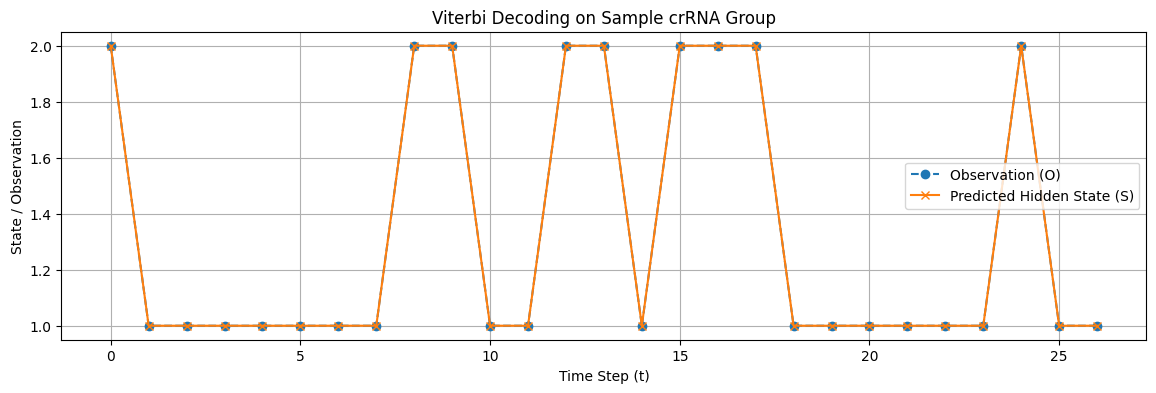

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(sample_obs_seq, label='Observation (O)', marker='o', linestyle='--')
plt.plot(viterbi_states, label='Predicted Hidden State (S)', marker='x')
plt.title("Viterbi Decoding on Sample crRNA Group")
plt.xlabel("Time Step (t)")
plt.ylabel("State / Observation")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
def test_hmm_on_new_data(dna_list, crrna_list, transition_matrix, emission_matrix):
    test_df = pd.DataFrame({"DNA": dna_list, "crRNA": crrna_list})

    test_df["mismatch_count"] = test_df.apply(lambda row: compute_mismatch(row["DNA"], row["crRNA"]), axis=1)
    test_df["gc_content"] = test_df["DNA"].apply(compute_gc_content)
    test_df["alignment_score"] = test_df.apply(lambda row: needleman_wunsch(row["DNA"], row["crRNA"]), axis=1)
    
    # Categorize observation
    test_df["observation"] = test_df.apply(categorize_observation, axis=1)
    
    # Extract obs sequence
    obs_seq = test_df["observation"].tolist()
    
    # Run Viterbi
    state_seq = viterbi(obs_seq, transition_matrix, emission_matrix)

    test_df["predicted_state"] = state_seq
    return test_df[["DNA", "crRNA", "mismatch_count", "gc_content", "alignment_score", "observation", "predicted_state"]]


# Example DNA and crRNA sequences
sample_dna = [
    "GCTGCCAGTACAGGCTCCCCCTCG",
    "TACTAGAGTGACAAGTCACACAAT",
    "ACAGCGAGTACAAGCTCATCATGA"
]

sample_crrna = [
    "GCAGCCAGTACA_GCTCACCATGG",
    "G_CTAGAGTCACAAGTCCCACAGG",
    "GCAGCCAGTAC_AGCTCACCATGG"
]

# Generate result_df using the test_hmm_on_new_data function
result_df = test_hmm_on_new_data(sample_dna, sample_crrna, transition_matrix, emission_matrix)

# Count occurrences of each state
state_counts = result_df["predicted_state"].value_counts().sort_index()
total = len(result_df)

binding_efficiency = (state_counts.get(2, 0) / total) * 100
weak_binding_pct = (state_counts.get(1, 0) / total) * 100
no_binding_pct = (state_counts.get(0, 0) / total) * 100

print(f"🔬 Binding Efficiency: {binding_efficiency:.2f}%")
print(f"🟡 Weak Binding: {weak_binding_pct:.2f}%")
print(f"❌ No Binding: {no_binding_pct:.2f}%")



🔬 Binding Efficiency: 33.33%
🟡 Weak Binding: 66.67%
❌ No Binding: 0.00%


In [17]:
sample_dna = [
    "GCTGCCAGTACAGGCTCCCCCTCG",
    "TACTAGAGTGACAAGTCACACAAT",
    "ACAGCGAGTACAAGCTCATCATGA"
]

sample_crrna = [
    "GCAGCCAGTACA_GCTCACCATGG",
    "G_CTAGAGTCACAAGTCCCACAGG",
    "GCAGCCAGTAC_AGCTCACCATGG"
]

result_df = test_hmm_on_new_data(sample_dna, sample_crrna, transition_matrix, emission_matrix)
print(result_df)


                        DNA                     crRNA  mismatch_count  \
0  GCTGCCAGTACAGGCTCCCCCTCG  GCAGCCAGTACA_GCTCACCATGG               4   
1  TACTAGAGTGACAAGTCACACAAT  G_CTAGAGTCACAAGTCCCACAGG               5   
2  ACAGCGAGTACAAGCTCATCATGA  GCAGCCAGTAC_AGCTCACCATGG               4   

   gc_content  alignment_score  observation  predicted_state  
0    0.708333             14.0            2                2  
1    0.375000             12.0            1                1  
2    0.458333             14.0            1                1  
